In [10]:
import pandas as pd
import numpy as np
import os
import sys
from  networkx import bipartite
sys.path.append('./../..')
sys.path.append('./..')
import glob
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed
from pandarallel import pandarallel

pandarallel.initialize()
import re
import yaml
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

id_col = 'PanjivaRecordID'
import networkx as nx
import operator
import collections
import argparse
from networkx.algorithms import community
CONFIG = None
DIR_LOC = None
CONFIG = None
CONFIG_FILE = 'config.yaml'
save_dir = None
id_col = 'PanjivaRecordID'
use_cols = None
freq_bound = None
attribute_columns = None
DIR = None
CUT_OFF = None

def set_up_config(_DIR=None):
    global DIR
    global CONFIG
    global CONFIG_FILE
    global use_cols
    global num_neg_samples
    global DATA_SOURCE
    global DIR_LOC
    global save_dir
    global id_col
    global attribute_columns

    DATA_SOURCE = './../generated_data_v1/'
    with open(CONFIG_FILE) as f:
        CONFIG = yaml.safe_load(f)

    if _DIR is not None:
        DIR = _DIR
        CONFIG['DIR'] = _DIR
    else:
        DIR = CONFIG['DIR']

    DIR_LOC = re.sub('[0-9]', '', DIR)
    DATA_SOURCE = os.path.join(DATA_SOURCE, DIR)
    save_dir = 'stage_2'
    save_dir = os.path.join(
        DATA_SOURCE,
        save_dir
    )

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    use_cols = CONFIG[DIR]['use_cols']
    _cols = list(use_cols)
    _cols.remove(id_col)
    attribute_columns = list(sorted(_cols))
    return

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [11]:
# # ====================================
# #
# # ====================================
# def main(
#         DIR,
#         init_seed_count=10,
#         min_oh_nbr_count=2,
#         seed_degree_upper_bound=None
# ):
#     global DATA_SOURCE
#     global save_dir

In [12]:
DIR = 'us_import1'
set_up_config()

In [34]:
# =============================
# Main utility function
# =============================
def get_clusters(G, comm, max_pairs = 1, max_indirect_nbr_count = 3):
    import operator 
    global CUT_OFF
    DEGREE_LB = 3
    DEGREE_UB = CUT_OFF

    sg_obj = G.subgraph(comm)
    edgeWt_dict = {}
    for e in sg_obj.edges():
        edgeWt_dict[e] = sg_obj.get_edge_data(e[0],e[1])['weight']
        # 50% of weights

    wt_lb = 2
    wt_ub = 10
    candidate_edges = {}

    for edge,wt in edgeWt_dict.items():
        if wt <= wt_lb or wt > wt_ub: continue 
        if  sg_obj.degree(e[0]) <= DEGREE_LB and sg_obj.degree(e[1]) <= DEGREE_LB :continue
        if  sg_obj.degree(e[0]) > DEGREE_UB or sg_obj.degree(e[1]) > DEGREE_UB :continue
        
    #     print(edge, wt ,(sg_obj.degree(e[0]),sg_obj.degree(e[1])))
        candidate_edges[edge] = wt * ((sg_obj.degree(e[0])+sg_obj.degree(e[1]))/2 )/ DEGREE_UB
    candidate_edges  = sorted(candidate_edges.items(),key = operator.itemgetter(1),reverse=True)
    # --------------------
    np.random.shuffle(candidate_edges)
    count = 0
    
    marked_edges =[]
    for edge_item in candidate_edges:
        node1 = edge_item[0][0]
        node2 = edge_item[0][1]
        
        n1_nbr = None
        n2_nbr = None
        try:
            n1_nbr = np.random.choice([_ for _ in sg_obj.neighbors(node1) if sg_obj.degree(_)> DEGREE_LB and sg_obj.degree(_) < DEGREE_UB and _!= node2],1)[0]
            n2_nbr = np.random.choice([_ for _ in sg_obj.neighbors(node2) if sg_obj.degree(_)> DEGREE_LB and  sg_obj.degree(_) < DEGREE_UB and  _!= node1],1)[0]
            print('>>', n1_nbr,n2_nbr)
        except: 
            continue
        if n1_nbr is  None or n2_nbr is  None:
            continue
        # find neighbors of n1_nbr and n2_nbr   
        try:
            valid_nbrs = [N for N in sg_obj.neighbors(n1_nbr) if N!= node1 and N not in list(sg_obj.neighbors(node2)) ]
            node1_nbr_2 = set(np.random.choice(valid_nbrs, max_indirect_nbr_count, replace=True))
            valid_nbrs = [N for N in sg_obj.neighbors(n2_nbr) if N!= node2 and N not in list(sg_obj.neighbors(node1)) ]
            node2_nbr_2 = set(np.random.choice(valid_nbrs, max_indirect_nbr_count, replace=True))

#             print(node1_nbr_2, node2_nbr_2)
        except: continue
     
        target_nodes = [node1,node2,n1_nbr,n2_nbr]
        target_nodes.extend(node1_nbr_2)
        target_nodes.extend(node2_nbr_2)
        
        new_subgraph = sg_obj.subgraph(target_nodes)
        print(new_subgraph.edges(), new_subgraph.number_of_edges(),new_subgraph.number_of_nodes())
        marked_edges.extend(new_subgraph.edges())
        count +=1
        if count >= max_pairs: break    
            
    return marked_edges
  

def check_degree_distribution(graph_obj):
    degree_sequence = sorted([d for n, d in graph_obj.degree()], reverse=True)
    try:
        plt.title('Boxplot of degree')
        plt.boxplot(degree_sequence)
        plt.show()
    except:
        pass
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    try:
        fig, ax = plt.subplots()
        plt.bar(deg, cnt, width=0.80, color="b")
        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        plt.show()
    except:
        pass
    
def get_largest_component_subgraph(graph_obj):
    component_id = 0
    components = {}
    component_size_dict = {}

    for c in nx.connected_components(graph_obj):
        components[component_id] = c
        component_size_dict[component_id] = len(c)
        component_id += 1
    component_size_dict = sorted(component_size_dict.items(), key=operator.itemgetter(1), reverse=True)
    # Get the largest connected component
    max_component = components[component_size_dict[0][0]]
    subgraph = graph_obj.subgraph(max_component)
    return subgraph

def main_process():
    global DIR 
    global DATA_SOURCE
    global CUT_OFF
    # =======================================
    company_cols = ['ConsigneePanjivaID', 'ShipperPanjivaID']
    company_col_abbr = {'C': 'ConsigneePanjivaID', 'S': 'ShipperPanjivaID'}
    # -----------------------------------------------------------
    # Before creating community out of nodes - this flag modulates - whether to prune high degree edges premptively
    # setting to false  so that "cluster/community" is better captured
    # ------------------------------------------------------------
    PRE_PRUNE_BY_DEGREE = False
    # -----------------------------------------------------------
    # Total anomalies should be approximately between 5 to 10%
    # -----------------------------------------------------------
    ANOM_PERC_THRESHOLD_LB = 2.50
    ANOM_PERC_THRESHOLD_UB = 6.25
    # -----------------------------------------------------------
    # generate anomalies from top k communities by size
    TOP_K_COMMUNITIES = 10 
    # ------------------------------------------------------------

    df = pd.read_csv(
        os.path.join(DATA_SOURCE, 'train_data.csv'),
        low_memory=False,
        index_col=None
    )
    attributes = [ _ for _ in list(df.columns) if _ not in id_col]
    df = df.drop_duplicates(subset = attributes)
    df_subset = df[company_cols].groupby(
        company_cols).size().reset_index(
        name='count').sort_values(by='count', ascending=False)

    df_subset['ConsigneePanjivaID'] = df_subset['ConsigneePanjivaID'].apply(
        lambda x: 'C' + str(x)
    )

    df_subset['ShipperPanjivaID'] = df_subset['ShipperPanjivaID'].apply(
        lambda x: 'S' + str(x)
    )

    # --------------------
    # Create a bipartite graph
    # --------------------
    B = nx.Graph()
    B.add_nodes_from(set(df_subset['ConsigneePanjivaID'].values), bipartite=0)
    B.add_nodes_from(set(df_subset['ShipperPanjivaID'].values), bipartite=1)
    edges = []
    for i, j, k in zip(df_subset['ConsigneePanjivaID'].values,
                       df_subset['ShipperPanjivaID'].values,
                       df_subset['count'].values):
        edges.append((i, j, {'weight': k}))

    B.add_edges_from(edges)
    print(' IS the bipartite graph of Comapnies connected ? ', nx.is_connected(B))

    #  ---------------------------
    # Remove nodes that are in 90th percentile of degree or more
    # That is remove companies that are higly connected - since those are visible and deemed not suspicous/malacious
    # ----------------------------
    degree_sequence = sorted([d for n, d in B.degree()], reverse=True)
    CUT_OFF = int(np.percentile(degree_sequence, 90))
    print(' cut off degree ', CUT_OFF)

    # ====================================================================================
    # if PRE_PRUNE_BY_DEGREE == True
    # Remove nodes of high degree beforehand
    # ====================================================================================
    if PRE_PRUNE_BY_DEGREE == True:
        nodes_to_remove = [n for n, d in B.degree() if d > CUT_OFF]
        B1 = nx.Graph(B)
        B1.remove_nodes_from(nodes_to_remove)
        print('Number of nodes and edges', B1.number_of_edges(), B1.number_of_nodes())
    else:
        B1 = nx.Graph(B)

    # =====================================================================================
    # Largest connected component in the bipartite graph , after pruning high degree nodes   
    # ======================================================================================
    B2 = get_largest_component_subgraph(B1)
    check_degree_distribution(B2)
    print('Number of nodes and edges', B2.number_of_edges(), B2.number_of_nodes())
    # ==========================================
    # Parititon the graph into communities 
    # ==========================================

    communities = community.greedy_modularity_communities(B2)
    df_test = pd.read_csv(
        os.path.join(DATA_SOURCE, 'test_data.csv'),
        low_memory=False,
        index_col=None
    )
    df_test= df_test.drop_duplicates(subset=attribute_columns)

    edge_list = []
    while True:
        all_marked = []
        for i in range(0,TOP_K_COMMUNITIES):
            edges = get_clusters(B2, communities[i], max_pairs=1, max_indirect_nbr_count=5)
            all_marked.extend(edges)
        all_marked = [sorted(_) for _ in all_marked]

        record_count = 0
        for pair in all_marked:
            record_count +=len(df_test.loc[(df_test['ConsigneePanjivaID']== int(pair[0][1:]))|(df_test['ShipperPanjivaID']==int(pair[1][1:]))])
        percentage = record_count/len(df_test) *100
        print(' [  ======   ]',percentage)
        if percentage >= ANOM_PERC_THRESHOLD_LB and percentage <= ANOM_PERC_THRESHOLD_UB: break
        edge_list = all_marked
    return edge_list

In [35]:
# set_up_config(
#     DIR
# )

In [36]:
# init_seed_count=10
# one_hop_nbr_count=3
# seed_degree_upper_bound = None

 IS the bipartite graph of Comapnies connected ?  False
 cut off degree  7


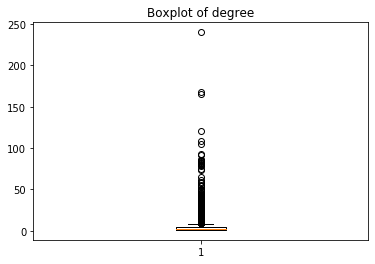

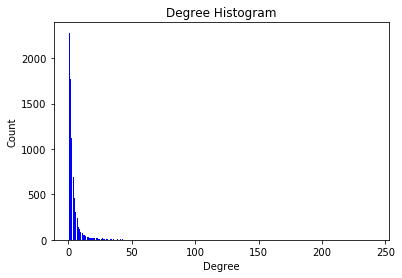

Number of nodes and edges 16836 7773
>> C1110 S2136
[('S1939', 'C4377'), ('S1939', 'C1110'), ('C1110', 'S3820'), ('C1110', 'S3341'), ('C4377', 'S2136'), ('C2521', 'S2136'), ('S2136', 'C1294'), ('S2136', 'C1987')] 8 9
>> S1702 C3361
[('S3276', 'C3361'), ('S1708', 'C3361'), ('S1702', 'C3593'), ('S1702', 'C1924'), ('S5502', 'C3361'), ('S1748', 'C3593'), ('S1748', 'C3361'), ('S3263', 'C3361')] 8 9
>> C1027 S3743
[('S5133', 'C1027'), ('S3756', 'C1027'), ('S4858', 'C1027'), ('S4858', 'C2046'), ('C2046', 'S3743'), ('C218', 'S3743'), ('S3743', 'C1813'), ('S3743', 'C1027'), ('S2675', 'C1813'), ('S2675', 'C1027')] 10 9
 [  ======   ] 8.561029785639736
>> C2140 S1336
[('C2140', 'S747'), ('C2140', 'S4512'), ('C2140', 'S4830'), ('C3805', 'S1336'), ('C2740', 'S1336'), ('S1336', 'C287'), ('C287', 'S4830')] 7 8
>> S5043 C1745
[('C429', 'S5043'), ('S5043', 'C3333'), ('S5043', 'C2511'), ('C1745', 'S1711'), ('C1745', 'S4101'), ('C1745', 'S2736'), ('C1745', 'S5262'), ('C3333', 'S1711')] 8 9
>> C1027 S3743

[['C521', 'S5136'],
 ['C3484', 'S5136'],
 ['C1527', 'S2247'],
 ['C3080', 'S5136'],
 ['C3437', 'S5136'],
 ['C1527', 'S279'],
 ['C1527', 'S3754'],
 ['C3080', 'S3754'],
 ['C3601', 'S4581'],
 ['C580', 'S4581'],
 ['C3601', 'S1679'],
 ['C3975', 'S438'],
 ['C3138', 'S438'],
 ['C2249', 'S438'],
 ['C1651', 'S438'],
 ['C580', 'S438'],
 ['C3601', 'S5343'],
 ['C1027', 'S5133'],
 ['C1027', 'S3756'],
 ['C1027', 'S4858'],
 ['C2046', 'S4858'],
 ['C2046', 'S3743'],
 ['C218', 'S3743'],
 ['C1813', 'S3743'],
 ['C1027', 'S3743'],
 ['C1813', 'S2675'],
 ['C1027', 'S2675']]

In [37]:
main_process()

 IS the bipartite graph of Comapnies connected ?  False


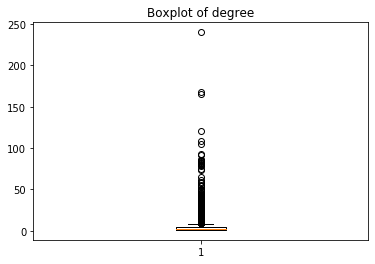

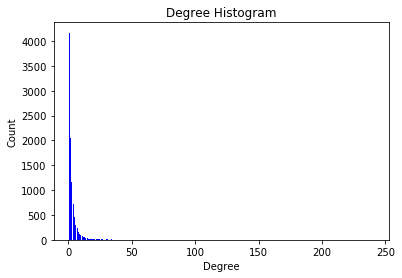

In [22]:
check_degree_distribution(B)

 cut off degree  7


Number of nodes and edges 16836 7773


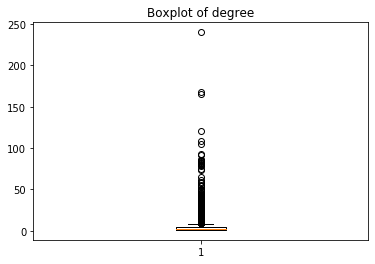

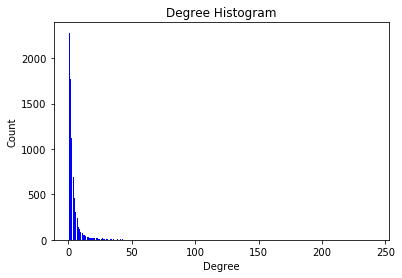

In [16]:
len(communities)

75

In [29]:
one_hop_nbr_count = 3
min_seed_degree = one_hop_nbr_count

In [30]:
def find_one_hop_neigbbor(G, target_node, degree_upper_bound, exclusion_list=None, count=-1):
    onehop_nbrs = []
    
    for n0 in G.neighbors(target_node):
        if exclusion_list is not None and n0 in exclusion_list : continue
        for n1 in G.neighbors(n0):
            if n1 ==  target_node: continue
            if G.degree(n1) > degree_upper_bound:  continue
            
            # n1 should have same type as target node
            if G.get_edge_data(n0, n1)['weight']>=3 and G.get_edge_data(target_node, n0)['weight']>=3:
                onehop_nbrs.append(n1)
               
    onehop_nbrs = set(onehop_nbrs)
    onehop_nbrs = list(onehop_nbrs)
    if count == -1: count = len(onehop_nbrs)
    try:
        return np.random.choice(onehop_nbrs, count, replace=False)
    except:
        return onehop_nbrs

In [99]:
def process_subgraph(sg_obj, init_seed_count = 3):
    print('---')
    global CUT_OFF
    global min_seed_degree
    global one_hop_nbr_count
    max_seed_degree = CUT_OFF
    
    node_dict = {}
    for n in sg_obj.nodes():
        _type = n[0]
      
        if _type in node_dict.keys():
            node_dict[_type].append(n)
        else:
            node_dict[_type] = [n]
    
    seed_dict = {}
    for _type, _list in node_dict.items():
        lower_bound = min_seed_degree
        _list = [n for n in _list if sg_obj.degree(n) >= lower_bound and sg_obj.degree(n) < max_seed_degree]
        if len(_list)==0: 
            seed_dict[_type] = []
        else:
            seed_dict[_type] = np.random.choice(
                _list, 
                replace=False, 
                size=min(init_seed_count,len(_list))
            )  
    
    print('Seed nodes', seed_dict)   
    seed_bipartite_nbrs = {}
    for n_type in ('C', 'S'):
        seed_bipartite_nbrs[n_type] = []
        nbrs = []
        for n in seed_dict[n_type]:
            nbrs.extend(
                [n1 for n1 in sg_obj.neighbors(n) 
                 if sg_obj.degree(n1) <= CUT_OFF and sg_obj.get_edge_data(n, n1)['weight']>=2] 
            )
        nbrs = list(set(nbrs))
        
        if len(nbrs)> 0 :
            n_type = nbrs[0][0]
            seed_bipartite_nbrs[n_type] = nbrs
        else:
            seed_bipartite_nbrs[n_type] = []
    print('Seed neighbors', seed_bipartite_nbrs)
    # -------------------------
    # Find 1-hop neighbors ( of the same type )
    one_hop_nbrs = {}
    for n_type in seed_dict.keys():
        one_hop_nbrs[n_type] = []
        
        if n_type=='S': nbr_type = 'C'
        else: nbr_type = 'S' 
        res =[]
        for node in seed_dict[n_type]:
            n = find_one_hop_neigbbor(
                G = sg_obj,
                target_node = node, 
                degree_upper_bound = CUT_OFF, 
                exclusion_list = list(seed_dict[n_type]) + list(seed_bipartite_nbrs[n_type]) , 
                count = one_hop_nbr_count
            )
            res.extend(n)
        one_hop_nbrs[n_type] = res
    print('One hop neighbors', one_hop_nbrs)
    return seed_dict, seed_bipartite_nbrs, one_hop_nbrs

In [ ]:
def process_subgraph_v2(sg_obj, init_seed_count = 3, min_connection_weight = 3):
    print('---')
    global CUT_OFF
    global min_seed_degree
    global one_hop_nbr_count
    max_seed_degree = CUT_OFF
    
    
    # 1. Select edges 
    for e in sg_obj.edges():
        if 
    return 


    node_dict = {}
    for n in sg_obj.nodes():
        _type = n[0]
      
        if _type in node_dict.keys():
            node_dict[_type].append(n)
        else:
            node_dict[_type] = [n]
    
    seed_dict = {}
    for _type, _list in node_dict.items():
        lower_bound = min_seed_degree
        _list = [n for n in _list if sg_obj.degree(n) >= lower_bound and sg_obj.degree(n) < max_seed_degree]
        if len(_list)==0: 
            seed_dict[_type] = []
        else:
            seed_dict[_type] = np.random.choice(
                _list, 
                replace=False, 
                size=min(init_seed_count,len(_list))
            )  
    
    print('Seed nodes', seed_dict)   
    seed_bipartite_nbrs = {}
    for n_type in ('C', 'S'):
        seed_bipartite_nbrs[n_type] = []
        nbrs = []
        for n in seed_dict[n_type]:
            nbrs.extend(
                [n1 for n1 in sg_obj.neighbors(n) 
                 if sg_obj.degree(n1) <= CUT_OFF and sg_obj.get_edge_data(n, n1)['weight']>=2] 
            )
        nbrs = list(set(nbrs))
        
        if len(nbrs)> 0 :
            n_type = nbrs[0][0]
            seed_bipartite_nbrs[n_type] = nbrs
        else:
            seed_bipartite_nbrs[n_type] = []
    print('Seed neighbors', seed_bipartite_nbrs)
    # -------------------------
    # Find 1-hop neighbors ( of the same type )
    one_hop_nbrs = {}
    for n_type in seed_dict.keys():
        one_hop_nbrs[n_type] = []
        
        if n_type=='S': nbr_type = 'C'
        else: nbr_type = 'S' 
        res =[]
        for node in seed_dict[n_type]:
            n = find_one_hop_neigbbor(
                G = sg_obj,
                target_node = node, 
                degree_upper_bound = CUT_OFF, 
                exclusion_list = list(seed_dict[n_type]) + list(seed_bipartite_nbrs[n_type]) , 
                count = one_hop_nbr_count
            )
            res.extend(n)
        one_hop_nbrs[n_type] = res
    print('One hop neighbors', one_hop_nbrs)
    return seed_dict, seed_bipartite_nbrs, one_hop_nbrs

def get_nodes(G, comm, max_pairs = 1, max_indirect_nbr_count = 3):
    import operator 
    DEGREE_LB = 2
    DEGREE_UB = 7

    sg_obj = G.subgraph(comm)
    edgeWt_dict = {}
    for e in sg_obj.edges():
        edgeWt_dict[e] = sg_obj.get_edge_data(e[0],e[1])['weight']
        # 50% of weights

    wt_lb = 2
    wt_ub = 15
    candidate_edges = {}

    for edge,wt in edgeWt_dict.items():
        if wt <= wt_lb or wt > wt_ub: continue 
        if  sg_obj.degree(e[0]) > DEGREE_UB or sg_obj.degree(e[1]) > DEGREE_UB :continue
        if  sg_obj.degree(e[0]) < DEGREE_LB and sg_obj.degree(e[1]) < DEGREE_LB :continue
    #     print(edge, wt ,(sg_obj.degree(e[0]),sg_obj.degree(e[1])))
        candidate_edges[edge] = wt

    candidate_edges  = sorted(candidate_edges.items(),key = operator.itemgetter(1),reverse=True)
    # --------------------
    
    _marked = []
    count = 0
    
    for edge_item in candidate_edges:
        node1 = edge_item[0][0]
        node2 = edge_item[0][1]

        if sg_obj.degree(node1) > sg_obj.degree(node2): 
            connector = node1
            pivot = node2
        else:
            connector = node2
            pivot = node1

        conn_nbrs = sg_obj.neighbors(connector)
        onehop_nbrs = {}
        j = 0
        for cn0 in conn_nbrs:
            for cn1 in sg_obj.neighbors(cn0):
                if cn1 ==  connector: continue
                if sg_obj.degree(cn1) > DEGREE_UB:  
                    continue
                if cn1 in sg_obj.neighbors(pivot): continue
                if len(set(_marked).intersection(set(sg_obj.neighbors(cn1)))) > 0 : continue  
                # n1 should have same type as connector
                if sg_obj.get_edge_data(cn0, cn1)['weight'] > wt_lb and sg_obj.get_edge_data(cn0, connector)['weight'] > wt_lb:
                    onehop_nbrs[cn1] = sg_obj.get_edge_data(cn0, cn1)['weight']
                print(connector, cn0, cn1)
                j += 1
                if j > max_indirect_nbr_count: break
        onehop_nbrs = {_[0]:_[1] for _ in sorted(onehop_nbrs.items(),key=operator.itemgetter(1),reverse=True)}

        if len(onehop_nbrs) == 0: 
            continue  
        _marked.append(node1)
        _marked.append(node2)
        _marked.extend(list(onehop_nbrs.keys())[:max_indirect_nbr_count])
        count +=1
        if count >= max_pairs:
            break
    return _marked

In [590]:
node_pairs = [ [ int(_[1:]) for _ in pair] for pair in all_marked]


In [591]:
df_test = pd.read_csv(
    os.path.join(DATA_SOURCE, 'test_data.csv'),
    low_memory=False,
    index_col=None
)
df_test= df_test.drop_duplicates(subset=attribute_columns)

In [592]:
# set_C = []
# set_S = []
# for a in all_marked:
#     if a[0] == 'S' : set_S.append(int(a[1:]))
#     else: set_C.append(int(a[1:]))
        
        

In [593]:
l = 0
for pair in node_pairs:
    l +=len(df_test.loc[(df_test['ConsigneePanjivaID']== pair[0])|(df_test['ShipperPanjivaID']==pair[1])])
2*l/len(df_test)

0.08793855540985361

In [594]:
len(df_test)

37367

In [595]:
2000/37000

0.05405405405405406

In [118]:
top_k_community_count = 12
pad = 0
set_C = set()
set_S = set()

for comm in communities[pad:top_k_community_count+pad]:
    sg = B2.subgraph(comm)
    print('Number of nodes and edges[Subgraph]', sg.number_of_edges(), sg.number_of_nodes())
    seed_nodes, seed_nbrs, seed_1_nbrs = process_subgraph(
       sg
    )
    if len(seed_1_nbrs['C']) == 0 or len(seed_1_nbrs['S']) == 0: continue
#     if len(seed_nbrs['C']) == 0 or len(seed_nbrs['S']) == 0: continue
    key = 'C'
#     set_C = set_C.union(set(seed_1_nbrs[key]))
    set_C =set_C.union(set(seed_nbrs[key]))
    set_C =set_C.union(set(seed_nodes[key]))
    key = 'S'
#     set_S = set_S.union(set(seed_1_nbrs[key]))
    set_S = set_S.union(set(seed_nbrs[key]))
    set_S = set_S.union(set(seed_nodes[key]))
    
    
    
    
    

Number of nodes and edges[Subgraph] 9954 3576
---
Seed nodes {'C': array(['C3497', 'C1085', 'C2252'], dtype='<U5'), 'S': array(['S1368', 'S3725', 'S1835'], dtype='<U5')}
Seed neighbors {'C': ['C1582', 'C3643'], 'S': []}
One hop neighbors {'C': [], 'S': ['S3643', 'S4695', 'S4717', 'S5212', 'S2798', 'S4809', 'S2153', 'S3181', 'S3945']}
Number of nodes and edges[Subgraph] 2242 1422
---
Seed nodes {'C': array(['C3408', 'C950', 'C939'], dtype='<U5'), 'S': array(['S3098', 'S5582', 'S2274'], dtype='<U5')}
Seed neighbors {'C': ['C809'], 'S': []}
One hop neighbors {'C': ['C4099', 'C849', 'C2424'], 'S': ['S1591', 'S4863', 'S4383', 'S1779', 'S5491']}
Number of nodes and edges[Subgraph] 1343 811
---
Seed nodes {'S': array(['S1689', 'S5598', 'S5410'], dtype='<U5'), 'C': array(['C789', 'C1109', 'C2755'], dtype='<U5')}
Seed neighbors {'C': ['C112', 'C3970', 'C4094', 'C3349'], 'S': []}
One hop neighbors {'S': ['S3547', 'S3315', 'S1708'], 'C': ['C938', 'C2585']}
Number of nodes and edges[Subgraph] 812 

In [119]:
len(set_S),len(set_C)

(12, 27)

In [120]:
set_S = [ int(_[1:]) for  _ in set_S]
set_C = [ int(_[1:]) for  _ in set_C]

In [121]:
df.loc[(df['ConsigneePanjivaID'].isin(set_C))|(df['ShipperPanjivaID'].isin(set_S))]

,PanjivaRecordID,Carrier,ConsigneePanjivaID,HSCode,PortOfLading,PortOfUnlading,ShipmentDestination,ShipmentOrigin,ShipperPanjivaID
154,107349053,311,2358,112,223,42,78,21,5041
216,106658109,349,989,64,65,53,100,98,2111
245,106863037,349,989,113,65,26,56,98,2111
552,107136893,340,3325,51,190,56,103,98,2086
633,106558206,100,1643,92,158,37,73,21,1853
...,...,...,...,...,...,...,...,...,...
129353,109206209,2,789,101,126,10,29,50,1726
129634,109793745,91,853,108,105,24,53,21,5041
129864,109369745,405,950,27,49,56,103,14,4060
130146,109092817,499,2168,104,158,5,15,21,3824


Number of nodes and edges 5518 7010


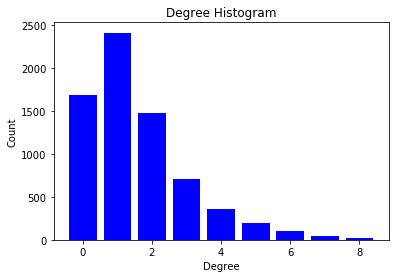

In [65]:
print('Number of nodes and edges', subgraph.number_of_edges(), subgraph.number_of_nodes())
degree_sequence = sorted([d for n, d in subgraph.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
try:
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color="b")
    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.show()
except:
    pass

In [25]:
subgraph.number_of_edges(), subgraph.number_of_nodes(),subgraph.is_directed()


(16836, 7773, False)

In [76]:
B1 = get_largest_component_subgraph(subgraph)
print('Number of nodes and edges', B1.number_of_edges(), B1.number_of_nodes())


Number of nodes and edges 16836 7773


In [14]:
degrees = [d for n, d in subgraph.degree()]
if seed_degree_upper_bound is None:
    seed_degree_upper_bound = np.percentile(degrees, 75)

In [15]:
seed_degree_upper_bound

4.0

In [16]:
# -----------------------------
# Select the set of seeds
# -----------------------------
# Per type seed count

min_seed_degree = min_oh_nbr_count + 1
max_seed_degree = min_seed_degree + 1
print(' Min, max of seed degree', min_seed_degree, max_seed_degree)

 Min, max of seed degree 5 6


In [22]:
node_dict = {}
for n in subgraph.nodes():
    _type = n[0]
    if _type in node_dict.keys():
        node_dict[_type].append(n)
    else:
        node_dict[_type] = [n]

seed_dict = {}
for _type, _list in node_dict.items():
    _list = [n for n in _list if subgraph.degree(n) >= min_seed_degree and subgraph.degree(n) <= max_seed_degree]
    seed_dict[_type] = np.random.choice(
        _list, 
        replace=False, 
        size=init_seed_count
    )

In [23]:
seed_dict

{'C': array(['C2814', 'C3471', 'C3221', 'C2821', 'C863', 'C1535', 'C78',
        'C1930', 'C1350', 'C2049'], dtype='<U5'),
 'S': array(['S4884', 'S2676', 'S3538', 'S5522', 'S1324', 'S480', 'S1368',
        'S1673', 'S4769', 'S1536'], dtype='<U5')}

In [26]:
# ==================================================
# Find one hop neighbors of these seeds
# Sample from them - to be labelled as "positive"
# ==================================================



In [35]:
seed_bipartite_nbrs = {'C': [], 'S': []}
for _type in ('C', 'S'):
    nbrs = []
    for n in seed_dict[_type]:
        nbrs.extend([n1 for n1 in subgraph.neighbors(n) if subgraph.degree(n1) <= seed_degree_upper_bound])
    nbrs = list(set(nbrs))
    # get C or S
    n_type = nbrs[0][0]
    seed_bipartite_nbrs[n_type] = nbrs

In [38]:
C_onehop_nbrs = []
for nc in seed_dict['C']:
    ohn = find_one_hop_neigbbor(
        subgraph, nc, seed_degree_upper_bound, exclsion_list= list(seed_dict['S']) + list(seed_bipartite_nbrs['S']), count=min_oh_nbr_count
    )
    C_onehop_nbrs.extend(ohn)

S_onehop_nbrs = []
for nc in seed_dict['S']:
    ohn = find_one_hop_neigbbor(
        subgraph, nc, seed_degree_upper_bound, exclsion_list=list(seed_dict['C'])  + list(seed_bipartite_nbrs['C']), count=min_oh_nbr_count)
    S_onehop_nbrs.extend(ohn)

In [70]:
seed_onehop_nbrs = {
    'S': S_onehop_nbrs,
    'C': C_onehop_nbrs
}

NameError: name 'S_onehop_nbrs' is not defined

In [41]:
len(S_onehop_nbrs),len(C_onehop_nbrs)

(38, 40)

In [42]:
# ==================================
# Accumulate the nodes of each type
# These are the ones that are "Bad"
# ==================================
target_nodes_dict = {_: [] for _ in company_col_abbr.values()}
for _type, _list in seed_dict.items():
    _type = company_col_abbr[_type]
    target_nodes_dict[_type].extend(_list)

for _type, _list in seed_bipartite_nbrs.items():
    _type = company_col_abbr[_type]
    target_nodes_dict[_type].extend(list())

for _type, _list in seed_onehop_nbrs.items():
    _type = company_col_abbr[_type]
    target_nodes_dict[_type].extend(_list)

for _type in target_nodes_dict.keys():
    target_nodes_dict[_type] = set([int(_[1:]) for _ in target_nodes_dict[_type]])
    print(len(target_nodes_dict[_type]))
    
    
# save_file = os.path.join(save_dir, 'seed_nodes.pkl')
# Save in a pickle file
#     with open(save_file, "wb") as fh:
#         pickle.dump(target_nodes_dict, fh, pickle.HIGHEST_PROTOCOL)

# ============================
# return target_nodes_dict

49
49


In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '--DIR', choices=['us_import1', 'us_import2', 'us_import3'],
    default='us_import1'
)

args = parser.parse_args()
DIR = args.DIR
set_up_config(
    DIR
)
target_nodes_dict = main(
    DIR,
    init_seed_count=25,
    min_oh_nbr_count=3
)